# ライブラリの読み込み

In [1]:
import networkx as nx
from networkx.algorithms import community
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import igraph
import seaborn as sns
%matplotlib inline

# グラフの生成
重み付き有向グラフを生成する．

In [2]:
N, p = 25, 0.2
alpha, beta = 1.0, 10.0

# グラフの生成
seed_for_graph = 990
G = nx.gnp_random_graph(N, p, seed = seed_for_graph, directed = True)
# エッジにweight属性をつける
edge_list = list(G.edges())
weight_list = [{"weight": np.random.beta(alpha, beta)} for _ in range(len(edge_list))]
dict_weight = dict(zip(edge_list, weight_list))
nx.set_edge_attributes(G, dict_weight)
A = nx.to_numpy_matrix(G, weight = "weight")

グラフのプロットの設定

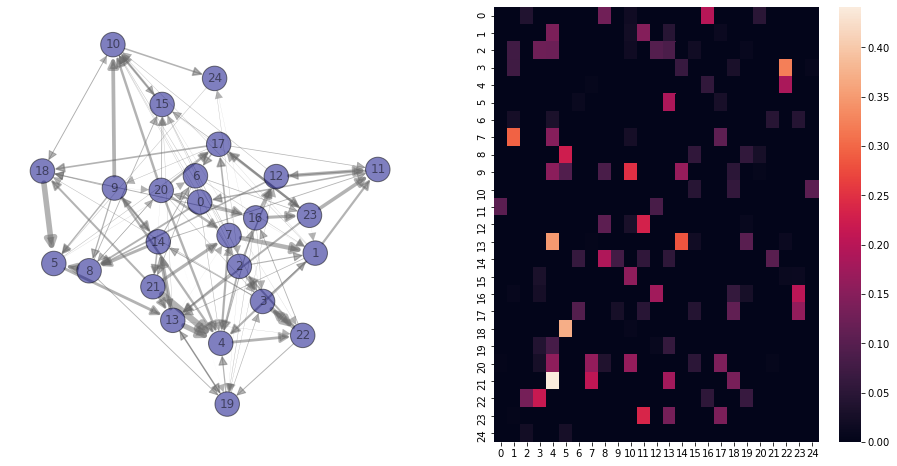

In [3]:
# ノードの設定
node_color = "indigo"
alpha = 0.5
edgecolors = "black"
edge_color = "dimgray"
node_size = 600
# エッジの設定
edge_color = "dimgray"
width = np.fromiter(nx.get_edge_attributes(G, "weight").values(), dtype = float)*15
arrowsize = 20
# その他の設定
seed_for_plot = 300
pos = nx.spring_layout(G, seed = seed_for_plot)

def plot_network(G, color_list, idx_sorted):
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(1, 2, 1)
    nx.draw(G, with_labels = True, pos = pos, cmap = plt.get_cmap("jet"), \
        node_size = node_size, node_color = color_list, alpha = alpha, edgecolors = edgecolors, \
        edge_color = edge_color, width = width, arrowsize = arrowsize)
    
    ax = fig.add_subplot(1, 2, 2)
    A_sorted = A[:, idx_sorted].copy()
    A_sorted = A_sorted[idx_sorted, :].copy()
    sns.heatmap(A_sorted)

color_list = [1 for _ in range(len(G.nodes()))]
idx_sorted = np.arange(len(color_list))
plot_network(G, color_list, idx_sorted)

# 無向グラフ化
ナイーブな無向グラフ化：$A_U = A + A^T$に対して，モジュラリティをもとにコミュニティ検出
https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity

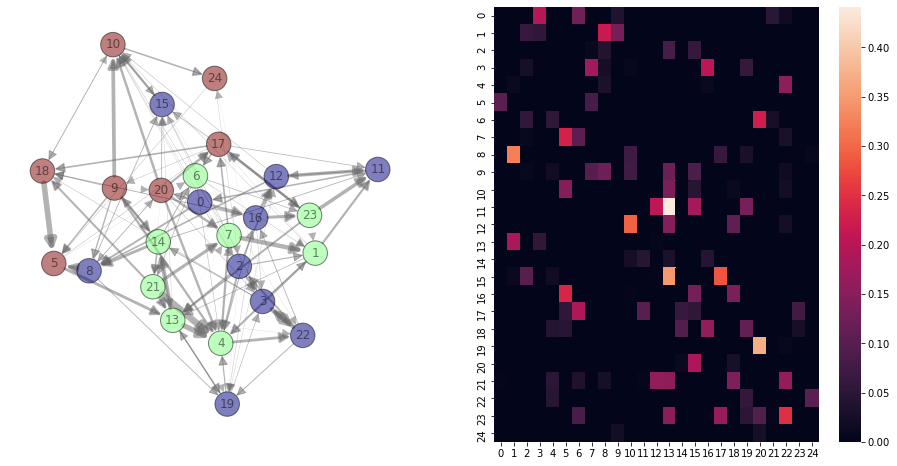

In [4]:
A_undirected = A + A.T
G_undirected = nx.from_numpy_array(A_undirected)
# resolutionのデフォルトは1だが，1より小さい場合大きなサイズのコミュニティを検出するようになる
community_list = community.greedy_modularity_communities(G_undirected, resolution = 1.0)

def get_color_list(community_list):
    color_list = [[] for _ in range(len(G_undirected.nodes()))]
    for idx_node, node in enumerate(G_undirected.nodes()):
        for idx_c, c in enumerate(community_list):
            if node in c:
                color_list[idx_node] = idx_c
    return color_list

color_list = get_color_list(community_list)
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

`Louvain`コミュニティ検出を用いる(無向グラフver.)

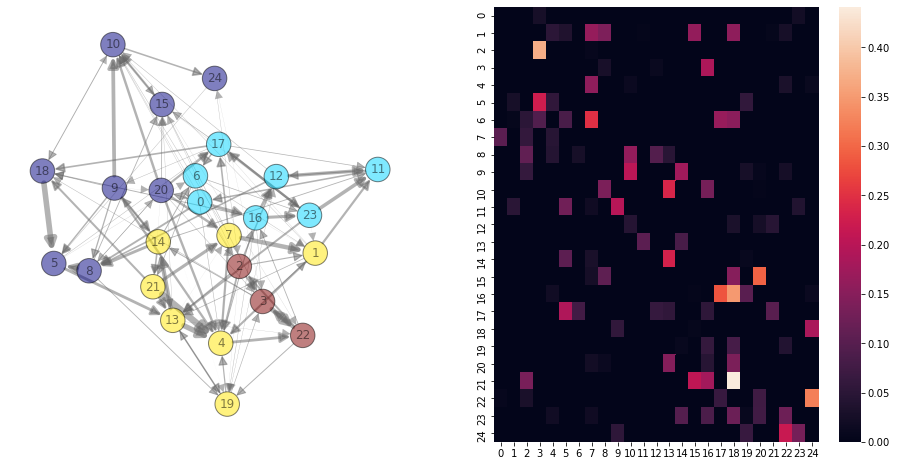

In [5]:
seed_partition = 334
community_list = community.louvain_communities(G_undirected, seed = seed_partition, weight = "weight")
color_list = get_color_list(community_list)
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

# 有向グラフに対するアルゴリズム

`Louvain`のコミュニティ検出アルゴリズム

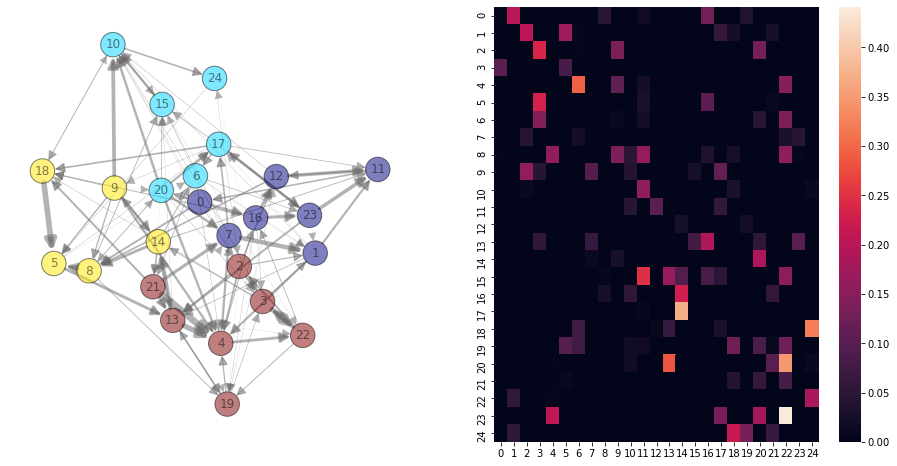

In [6]:
seed_partition = 3304
community_list = community.louvain_communities(G, weight = "weight", threshold = 2.0)
color_list = get_color_list(community_list)
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

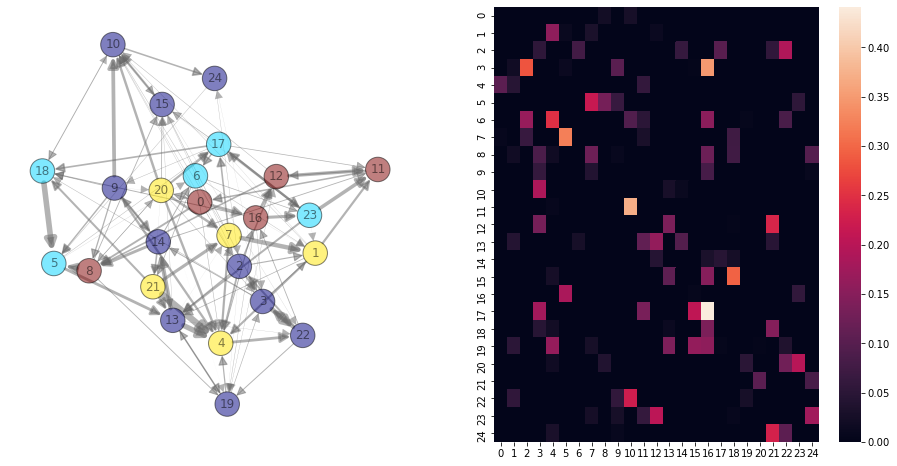

In [7]:
K = 4
pi = np.random.random(K)
pi = pi / pi.sum()
theta = np.random.random((K, N))
theta = theta / theta.sum(axis = 0)
T = 100
min_degree = 1
out_degree_list = np.array([min_degree+d for (node, d) in G.out_degree()])
A_modified = A + np.eye(N) * min_degree
out_degree_list = A_modified.sum(axis = 1)

for t in range(T):    
    q = np.exp(np.log(pi) + A_modified.dot(np.log(theta.T)))
    q = q / q.sum(axis = 1)
    pi = q.mean(axis = 0)
    theta = q.T.dot(A_modified) / q.T.dot(out_degree_list)

color_list = np.where(theta == theta.max(axis = 0), np.tile(np.arange(K), N).reshape(N, -1).T, 0).sum(axis = 0)
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

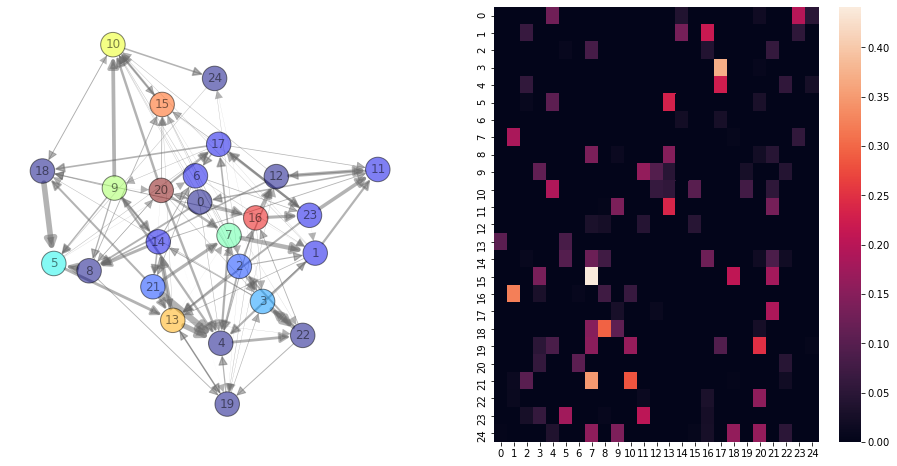

In [8]:
min_degree = 0.001 # 自分自身から自分自身にエッジが出ていると考える
pow_alpha, pow_beta = 0.5, 0.5
A_modified = A + np.eye(N) * min_degree
# in_degree_list = [(1.0/(min_degree+d)) for (node, d) in G.in_degree()]
in_degree_list = A_modified.sum(axis = 0).A1 # 末尾はmatrixからの変換に必要
D_in = np.diag(in_degree_list)
# out_degree_list = [(1.0/(min_degree+d)) for (node, d) in G.out_degree()]
out_degree_list = A_modified.sum(axis = 1).A1 # 末尾はmatrixからの変換に必要
D_out = np.diag(out_degree_list)
B = (D_out**pow_alpha).dot(A_modified).dot(D_in**(pow_beta)).dot(A_modified.T).dot(D_out**(pow_alpha))
C = (D_in**(pow_beta)).dot(A_modified.T).dot(D_out**(pow_alpha)).dot(A_modified.T).dot(D_in**(pow_beta))
A_undirected = B + C
G_undirected = nx.from_numpy_array(A_undirected)
community_list = community.greedy_modularity_communities(G_undirected)

color_list = get_color_list(community_list)
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

スピングラス法によるコミュニティ検出

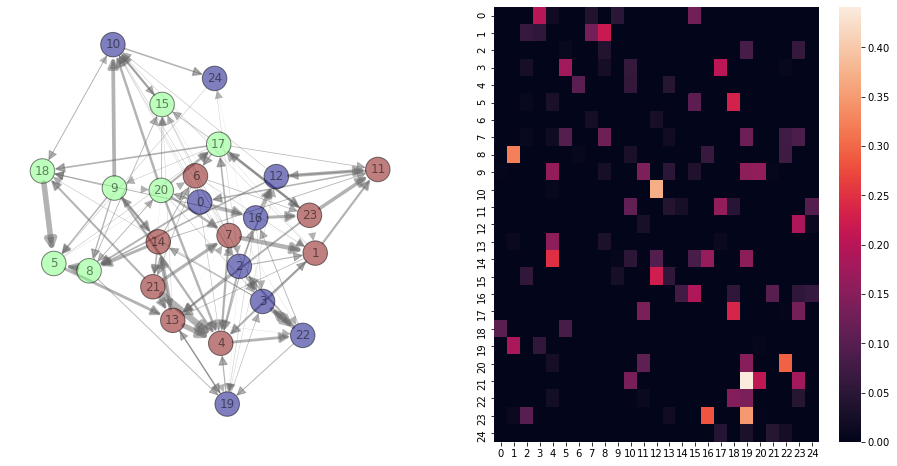

In [9]:
g = igraph.Graph.from_networkx(G)
color_list = g.community_spinglass(spins = 5, gamma = 1.0).membership
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)

# スピングラス法のテスト

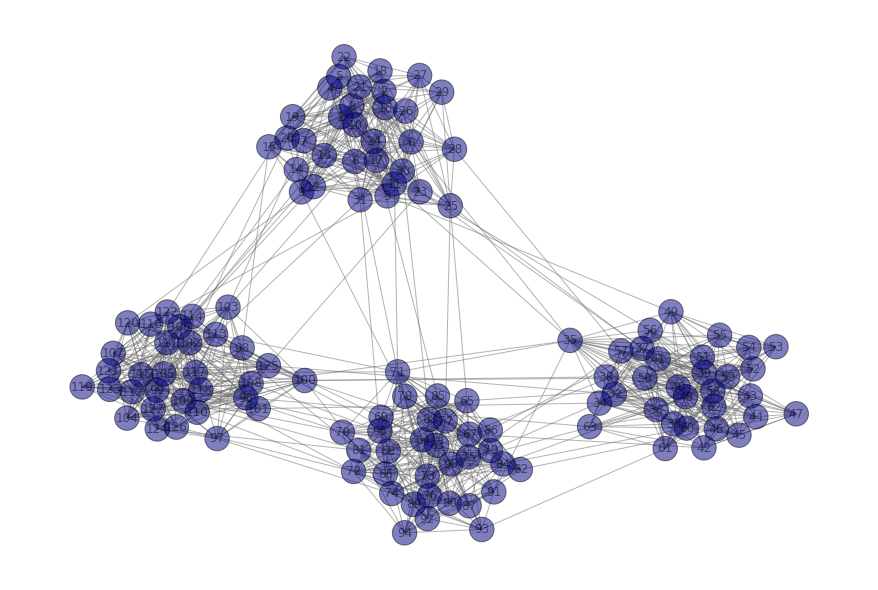

In [10]:
n1, n2, n3 = 8, 4, 4
k1, k2, k3 = 8, 8, 1
N = n1*n2*n3
p1, p2, p3 = k1/n1, k2/(n1*(n2-1)), k3 / N

G = nx.gnp_random_graph(N, p3, seed = seed_for_graph, directed = False)
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 != node2:
            # 属している最も細かいコミュニティが同じである場合
            if node1//n1 == node2//n1:
                G.add_edge(node1, node2)
            elif node1//(n1*n2) == node2//(n1*n2):
                if np.random.random() < p2*0.5:
                    G.add_edge(node1, node2)
A = nx.to_numpy_matrix(G, weight = "weight")

fig = plt.figure(figsize = (12, 8))
pos = nx.spring_layout(G, seed = seed_for_plot)
color_list = [1 for _ in range(len(G.nodes()))]
width = np.fromiter(nx.get_edge_attributes(G, "weight").values(), dtype = float)*20
nx.draw(G, with_labels = True, pos = pos, cmap = plt.get_cmap("jet"), \
    node_size = node_size, node_color = color_list, alpha = alpha, edgecolors = edgecolors, \
    edge_color = edge_color, width = width, arrowsize = arrowsize)

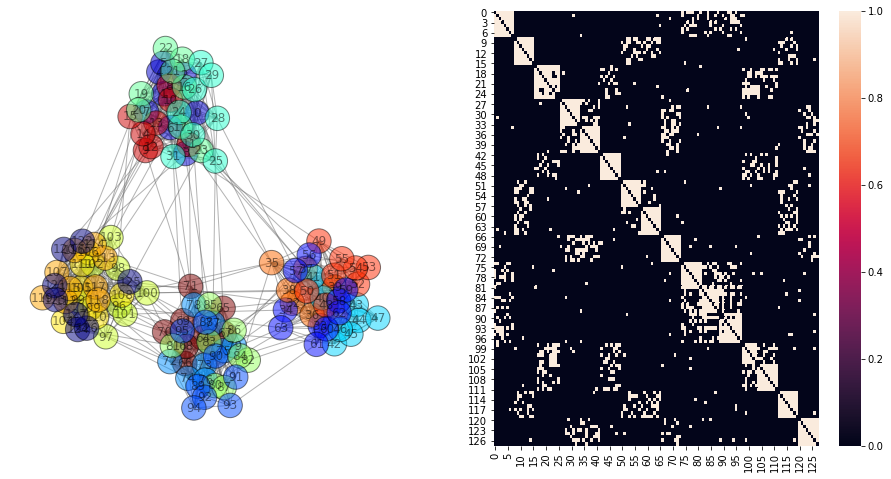

In [11]:
g = igraph.Graph.from_networkx(G)
color_list = g.community_spinglass(spins = 16, gamma = 4.0).membership
idx_sorted = np.argsort(color_list)
plot_network(G, color_list, idx_sorted)